# Sentiment Analysis of Tweets with Coronavirus/ Covid19 Hashtags
April Shin

### Focus:
We investigate the sentiment of tweets containing the hashtags *Coronavirus* and/or *Covid19* with and without Asian references.

### Methods:
- Clean dataset by the following:
    - Lowercase text
    - Remove words with backslash x
    - Remove website URLs
    - Removing links, special characters using simple regex statements
    - Remove stopwords
- Compute the polarity and normalized polarity scores of cleaned tweet texts using vader's polarity scores:
    - Polarity score is manually calculated using scores provided in vader's list of scores in vader_lexicon.txt
    - Normalized polarity score is calcuating using SentimentIntensityAnalyzer method from vaderSentiment.vaderSentiment module.
- Identify tweets with Asian reference and if user is a verified user
    - Tweets with any of the keywords such as 'asian', 'asians', 'chinese', 'china', and 'wuhan' are considered to have an Asian reference.
    - We define a 'verified' user to be a user with >= 9000 followers.
- Identify the top five tweets with most negative or positive polarity scores
- Plot the distributions and corresponding means of tweet polarities of various categories:
    - Tweets with and without Asian references
    - Tweets posted by 'verified' users vs 'normal' users

### Resulting DataFrame: 
The result will be stored in DataFrame *tweets_df* with the following columns:
- timestamp
- tweet_text
- username
- all_hashtags
- followers_count
- location
- clean_text
- polarity
- normalized_polarity
- verified_user

In [17]:
#pip install nltk
#pip install vaderSentiment

## Import needed files and libraries:

In [2]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from statistics import median, mean

[nltk_data] Downloading package stopwords to /Users/april/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Importing vader lexicon 
vader_lex = pd.read_csv('vader_lexicon.txt', 
                   sep='\t',
                   usecols=[0, 1], 
                   names=['token', 'polarity'],
                   index_col='token')

# Setting stopwords
stop_words = list(set(stopwords.words('english')))

In [4]:
# Importing tweets
csv_file = 'hashtagcoronavirus_covid19.csv'
column_name = 'tweet_text'

# Initializing DataFrame tweets_df
tweets_df = pd.read_csv(csv_file)
tweet_text = tweets_df.loc[:, (column_name)]

## Clean data and compute both normalized and non-normalized polarity:

In [5]:
def clean_tweet(tweet): 
    '''
    1. Lowercase text
    2. Remove words with backslash x
    3. Remove website urls
    4. Clean tweet text by removing links, special characters using simple regex statements. 
    5. Remove stopwords
    '''
    
    # 1. Lowercase text
    low = tweet.lower()
    
    # 2. Remove words with backslash x
    low_fil = " ".join(filter(lambda x:x[:2]!='\\x', low.split()))
    
    # 3. Remove website urls
    regexurl = r'http\S+'
    no_urls = low_fil.replace(regexurl, '')

    # 4. Clean tweet text by removing links, special characters using simple regex statements. 
    no_punct = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", no_urls).split())
    
    # 5. Remove stopwords
    cleaned = " ".join(filter(lambda x:x not in stop_words, no_punct.split()))
    
    return cleaned
    

In [6]:
# To compute normalized polarity

def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # object gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    return sentiment_dict['compound']

In [7]:
# Terms that refer to asian ethnic groups
asian_ref = ['asian', 'asians', 'chinese', 'china', 'wuhan', 'asia', 'oriental', 'asiatic', 'eastern']

# Creating new column with cleaned tweet texts
for i in range(len(tweet_text)):
    cleaned = clean_tweet(tweet_text[i][1:])
    tweets_df.at[i, "clean_text"] = cleaned
    
    # Selecting tweets with any reference to asian ethnic groups:
    if (pd.Series(cleaned.split()).isin(asian_ref).any()):
        tweets_df.at[i, "asian_ref"] = 1
    else:
        tweets_df.at[i, "asian_ref"] = 0
        
    # Computing normalized polarity using vader's sentiment_scores function
    tweets_df.at[i, "normalized_polarity"] = sentiment_scores(cleaned)
    
    
# Create column of users' verified status based on follower count
tweets_df['verified_user'] = tweets_df['followers_count'] >= 9000

### Computing non-normalized polarity:

In [8]:
# Converting tweets into tidy_format
tidy_format = (tweets_df["clean_text"].str.split(expand=True).stack().reset_index(level=1).rename(columns={'level_1': 'num', 0: 'word'}))

In [9]:
# Computing polarity of each tweet text by summing polarity of each word in text
# Polarity of each word based on vader's polarity in vader_lexicon.txt 
tweets_df['polarity'] = tidy_format.merge(vader_lex, how='left', left_on='word', right_index=True).reset_index().loc[:, ['index', 'polarity']].groupby('index').sum().fillna(0)

## Result:

### Updated DataFrame Containing All Tweets and Following Information:
timestamp, tweet_text, username, all_hashtags, followers_count, location, clean_text, polarity, normalized_polarity, verified_user

In [10]:
# Updated tweets DataFrame with additional clean_text, polarity, normalized_polarity, and verified_user columns
tweets_df

,timestamp,tweet_text,username,all_hashtags,followers_count,location,clean_text,asian_ref,normalized_polarity,verified_user,polarity
0,2020-04-14 02:31:35,b'He gets up every day? Hasn\xe2\x80\x99t caug...,b'bigmusicfan71',"['coronavirus', 'COVID19', '25thAmendmentNow']",354,b'',gets every day xe2 x80 x99t caught coronavirus...,0.0,0.0000,False,0.0
1,2020-04-14 02:31:35,b'@Welptheresthat @NorthmanTrader Not when the...,b'GKeeto',"['china', 'ChinaMustExplain', 'ChinaVirus', 'C...",6,b'',product complete chinese made garbage accounts...,1.0,0.0000,False,0.0
2,2020-04-14 02:31:34,b'Holy \xf0\x9f\x92\xa9 \xe2\x81\xa6@VanityFai...,b'DrumpfsLies',"['INCOMPETENCEKILLS', 'COVID19', 'coronavirus'...",230,"b'California, USA'",holy scorchingly amazing incompetencekills cov...,0.0,0.5859,False,2.8
3,2020-04-14 02:31:32,b'This could be the end of the line for cruise...,b'1petermartin',"['COVID19', 'coronavirus', 'ausecon', 'auspol']",32382,b'',could end line cruise ships covid19 coronaviru...,0.0,0.0000,True,0.0
4,2020-04-14 02:31:22,"b'Dear @CNN, Can you sincerely claim @realDon...",b'WarmMonkey',"['coronavirus', 'COVID19']",651,b'Out of The Closet',dear sincerely claim handling coronavirus cris...,0.0,0.6584,False,1.3
...,...,...,...,...,...,...,...,...,...,...,...
995,2020-04-14 01:34:17,b'@JimWTAE @WTAE And here is a third Smithfiel...,b'realhumanrights',"['Wisconsin', 'Cudahy', 'COVID19', 'coronaviru...",2853,b'Washington DC',third smithfield food plant wisconsin cudahy 2...,0.0,0.5574,False,2.6
996,2020-04-14 01:34:15,b'#TruthBeTold Abso-fucking-lutly!!! #Heartb...,b'AltBadDude',"['TruthBeTold', 'Heartbreaking', 'trumpsameric...",1308,"b'Maryland, USA'",truthbetold abso fucking lutly heartbreaking l...,0.0,-0.5829,False,-2.5
997,2020-04-14 01:34:15,b'Trump assembles his crew of X-Men to save us...,b'BoneKnightmare',"['EndOfDays', 'apocalypse2020', 'COVID19', 'co...",3760,b'Parts Unknown',trump assembles crew x men save us doomed endo...,0.0,-0.2500,False,-1.0
998,2020-04-14 01:34:14,"b'A shameful incident of Jaunpur, this is how ...",b'itemads',"['CoronaVirus', 'CoronaVirusPandemic', 'Corona...",63,b'Jeddah',shameful incident jaunpur misuse power happens...,0.0,-0.4939,False,-2.2


## A closer look at the most positive and negative tweets:

### Top 5 Most Positive:

In [11]:
tweets_asian = pd.DataFrame(tweets_df[tweets_df['asian_ref'] == 1.0])
print('Most positive tweets regarding #Coronavirus and #Covid19:')
t = tweets_asian.sort_values(by = ['polarity'], ascending=False)[['polarity', 'tweet_text']].head(5).reset_index()
for i in range(len(t)):
    print('\nPolarity: ', t['polarity'][i], "\nTweet Text: ", t['tweet_text'][i])

Most positive tweets regarding #Coronavirus and #Covid19:

Polarity:  4.7 
Tweet Text:  b'@peterbakernyt #COVID19 #CoronaVirus #Corona #SARSCoV2 #Corona19  \xf0\x9f\x98\xb7   Lol  Approximately 1.4 billion Chinese around the world call it \xe2\x80\x9cWuhan pneumonia\xe2\x80\x9d   \xe6\xad\xa6\xe6\xb1\x89\xe8\x82\xba\xe7\x82\x8e  There\xe2\x80\x99s your Chinese lesson for today.  \xf0\x9f\xa6\xa0'

Polarity:  3.4 
Tweet Text:  b'#Japan offers $2.2B to help domestic companies move production from #China, but will it help the imaging industry? https://t.co/SdNdcPG2TC #Coronavirus #Covid19 #economy'

Polarity:  3.3000000000000003 
Tweet Text:  b'These Asian artists are using their lockdown downtime to create music inspired by the coronavirus.  #COVID19 #coronavirus #lockdown #quarantine'

Polarity:  3.1 
Tweet Text:  b'CORONAVIRUS UPDATE:  STUNNING! US Gave Wuhan Lab $3.7 Million Grant to Study Horseshoe Bats that Carry Coronavirus #COVID19 #COVID2019 #coronavirus #COVID #Covid19usa #Coron

### Top 5 Most Negative

In [12]:
print('Most negative tweets regarding #Coronavirus and #Covid19:')
t = tweets_asian.sort_values(by = ['polarity'], ascending=True)[['polarity', 'tweet_text']].head(5).reset_index()
for i in range(len(t)):
    print('\nPolarity: ', t['polarity'][i], "\nTweet Text: ", t['tweet_text'][i])

Most negative tweets regarding #Coronavirus and #Covid19:

Polarity:  -10.2 
Tweet Text:  b'When Chinese are accusing Taiwanese of racial abuse to Tedros, they are even more racist to people with dark skin. How ironic. #fuckchina #wuhanvirus #chinavirus #ccpvirus #COVID19 #coronavirus #cardib #bitch https://t.co/ntEj8vgCki'

Polarity:  -6.6 
Tweet Text:  b'The death rate in Italy, Spain and France - three of the countries worst-affected by the coronavirus - appears to be slowing.  #coronavirus #CoronaOutbreak #Wuhan #China #COVID19 #India #COVID #CoronaVirusUpdate #ChineseVirus #WuhanVirus #US #Italy #Spain #Germany #France'

Polarity:  -5.2 
Tweet Text:  b'Fighting fake news: The new front in the coronavirus battle @AJENews   #coronavirus  #CoronaOutbreak #Wuhan #China #COVID19 #India #COVID #CoronaVirusUpdate #ChineseVirus #WuhanVirus #US #Italy #Spain #Germany #France #UK #Iran #WHO #FakeNews    https://t.co/Ks4lKhlxsL'

Polarity:  -3.8 
Tweet Text:  b"#Trump claims 'total authority

# Distribution of Tweet Polarities:
Median of all distributions below is equal to 0.

### Distribution of All Tweet Polarities:

In [13]:
max(tweets_df['polarity'])
mean_all = (mean(tweets_df['polarity']))
mean_all

0.1592

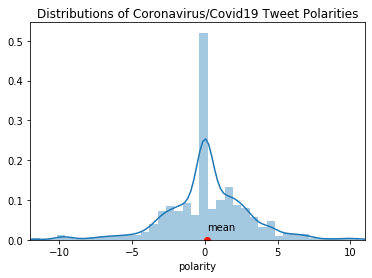

In [14]:
sns.distplot(tweets_df['polarity'])
plt.title('Distributions of Coronavirus/Covid19 Tweet Polarities')
plt.xlim(-12,11)
plt.plot(mean_all, 0, 'ro')
plt.annotate("mean", (mean_all, 0), textcoords="offset points", xytext=(0,10));

### Distribution of Tweet Polarities with Asian References:

In [15]:
# Selecting all tweets with asian reference
asian_ref_tweets = tweets_df.loc[tweets_df['asian_ref'] == 1.0]
mean_asian = (mean(asian_ref_tweets['polarity']))
mean_asian

-0.5194444444444444

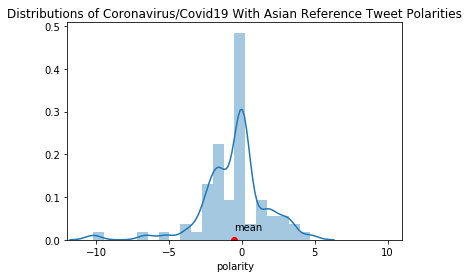

In [16]:
sns.distplot(asian_ref_tweets['polarity'])
plt.title('Distributions of Coronavirus/Covid19 With Asian Reference Tweet Polarities')
plt.xlim(-12,11)
plt.plot(mean_asian, 0, 'ro')
plt.annotate("mean", (mean_asian, 0), textcoords="offset points", xytext=(0,10));

### Combining Distribution of Tweet Polarities With/Without Asian References:

In [17]:
mean_no_asian = mean(tweets_df.loc[tweets_df['asian_ref'] == 0.0]['polarity'])
print("mean_no_asian: ", mean_no_asian)
print("mean_asian: ", mean_asian)

mean_no_asian:  0.21185344827586206
mean_asian:  -0.5194444444444444


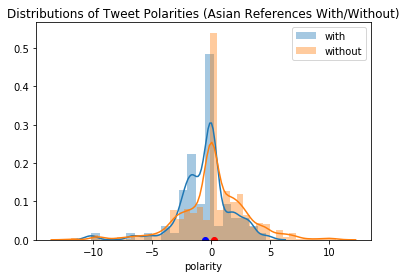

In [18]:
sns.distplot(tweets_df[tweets_df['asian_ref'] == 1.0]['polarity'])
sns.distplot(tweets_df[tweets_df['asian_ref'] == 0.0]['polarity'])
plt.legend(['with', 'without'])
plt.title('Distributions of Tweet Polarities (Asian References With/Without)')
plt.plot(mean_asian, 0, 'bo')
plt.plot(mean_no_asian, 0, 'ro')

In [19]:
asian_ref = tweets_df.loc[tweets_df['asian_ref'] == 1.0]['polarity'] < 0
pos_asian = pd.Series(asian_ref).where(lambda x: x == False).dropna()
neg_asian = pd.Series(asian_ref).where(lambda x: x == True).dropna()
if (len(pos_asian) - len(neg_asian)) < 0:
    asian_sentiment = "Negative"
else:
    asian_sentiment = "Positive"

print(len(pos_asian))
print(len(neg_asian))
print(asian_sentiment)
#sum_asian = sum(tweets_df.loc[tweets_df['asian_ref'] == 1.0]['polarity'])
#print("sum_no_asian: ", sum_no_asian)
#print("sum_asian: ",sum_asian)

#no_asian_ref = tweets_df.loc[tweets_df['asian_ref'] == 0.0]['polarity'] < 0
#neg_no_asian = pd.Series(no_asian_ref).where(lambda x: x == True).dropna()

#print(len(neg_asian))
#print(len(neg_no_asian))

41
31
Positive


### Distribution of Tweet Polarities (Verified Users VS. Normal Users)
Verified users have a high follower count and, consequently, can reach (and may or may not impact) a greater audience than non-verified users (as we call 'normal' users) of Twitter. Therefore, we are interested in comparing the polarity distribution of tweets posted verified users VS. normal users.

Text(0.5, 1.0, 'Distributions of Tweet Polarities (Verified Users vs. Normal Users)')

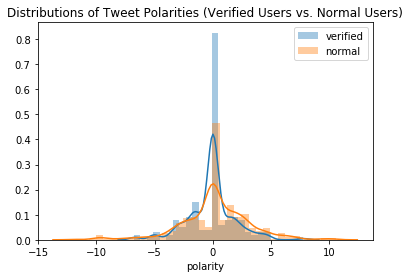

In [62]:
sns.distplot(tweets_df[tweets_df['verified_user'] == True]['polarity'])
sns.distplot(tweets_df[tweets_df['verified_user'] == False]['polarity'])
plt.legend(['verified', 'normal'])
plt.title('Distributions of Tweet Polarities (Verified Users vs. Normal Users)')

# Analysis in progress:

In [179]:
location_names = pd.read_csv('location_names.txt', 
                   sep='\t',
                   usecols=[0], 
                   names=['location_name'])

for i in range(len(location_names)):
    cleaned = clean_tweet(location_names['location_name'][i])
    location_names.at[i, "cleaned_loc_name"] = cleaned
    
location_names

,location_name,cleaned_loc_name
0,Afghanistan,afghanistan
1,Albania,albania
2,Algeria,algeria
3,American Samoa,american samoa
4,Andorra,andorra
...,...,...
360,WA,wa
361,WV,wv
362,WI,wi
363,WY,wy


In [205]:

loc = tweets_df.groupby('location')[['location', 'polarity']].first()['location']
pol = tweets_df.groupby('location')[['location', 'polarity']].first()['polarity']
dict = {'loc':loc, 'polarity':pol}
loc_pol = pd.DataFrame(dict).reset_index()[['loc','polarity']]

for i in range(len(loc_pol)):
    cleaned = clean_tweet(loc_pol['loc'][i][1:])
    loc_pol.at[i, "clean_loc"] = cleaned

    #print(pd.Series(cleaned.split()).isin(list(location_names['cleaned_loc_name'])).any())
    
    if (pd.Series(cleaned.split()).isin(list(location_names['cleaned_loc_name'])).any()):
        loc_pol.at[i, "real_location"] = 1
    else:
        loc_pol.at[i, "real_location"] = 0
    
    

(loc_pol[loc_pol['real_location'] == 1.0]['clean_loc'])
        
#loc_pol.first()['polarity']
#list(loc_pol.indices.keys())
#loc_pol
#pd.DataFrame
#clean_tweet(loc_pol['location'][0][1:])
#loc_pol.at[1, "cleaned_loc"] = "hellohelllo"

#for i in range(len(loc_pol)):
#    cleaned_loc = clean_tweet(loc_pol['location'][i][1:])
#    loc_pol.at[i, "clean_loc"] = cleaned_loc

0                 california dreamin
2                                usa
7      100 illinois street suite 200
9         1790 sequoia blvd tracy ca
10             2801 88th st omaha ne
                   ...              
409          waterloo ontario canada
413        west georgia east alabama
414       west london ontario canada
431                         oklahoma
434            somewhere western usa
Name: clean_loc, Length: 251, dtype: object

In [33]:
tweets_df.groupby('location')
#loc_tweets = tweets_df[['location', 'polarity']].groupby('location').mean().sort_values('polarity', ascending=False)
#print(loc_tweets.columns)
#for i in loc_tweets:
#    print(i['location'])
#loc_tweets#.drop(['planet earth'])